# 数据获取及表合并

In [49]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
plt.rcParams['font.sans-serif'] = ['SimHei', 'KaiTi', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
matplotlib.rcParams.update({"font.size": 12,'lines.linewidth': 2})

In [3]:
DATA_DIR = './data/'

# 从文件中导入数据到dataframe中
def get_df(file, header=None):
    df = pd.read_csv(file, header=None)
    # df.columns = DF_HEADER.get(key, df.columns)
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

dfjob = get_df(DATA_DIR + 'pai_job_table.csv')
dftask = get_df(DATA_DIR + 'pai_task_table.csv')
dfinstance = get_df(DATA_DIR + 'pai_instance_table.csv')
dfsensor = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfgroup = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp_spec = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm_metric = get_df(DATA_DIR + 'pai_machine_metric.csv')

### 小表jion到大表
#### dfa dataframe of tasks

In [6]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa = get_dfa(dftask, dfjob, dfinstance, dfgroup)

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


#### dfw dataframe of workers

In [7]:
def get_dfiw(dfi):
    dfiw = dfi.sort_values(['status','start_time','end_time'])
    dfiw.drop_duplicates(subset=['worker_name'], keep='last', inplace=True)
    dfiw.dropna(subset=['worker_name'], inplace=True)
    dfiw['runtime'] = dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['end_time'] \
                    - dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['start_time']
    dfiw.loc[dfiw.start_time==0, 'start_time'] = np.nan
    dfiw.loc[dfiw.start_time==0, 'end_time'] = np.nan
    return dfiw

def get_dfw(dfi, dft, dfg):
    dfw = get_dfiw(dfi)
    dfw['start_date']=dfw.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai')
    print('dfi + dft ...')
    dfw = dfw.merge(dft, on=['job_name','task_name'], how='left', suffixes=['', '_t'])
    print('dfi + dft + dfg ...')
    dfw = dfw.merge(dfg, on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfw.loc[dfw.group.isnull(),'group'] = dfw.loc[dfw.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfw

dfw = get_dfw(dfinstance, dftask, dfgroup)

dfi + dft ...
dfi + dft + dfg ...


#### dfws dataframe of worker with sensor data

In [8]:
dfws = dfw.merge(dfp_spec.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfsensor.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')

#### dfas dataframe of task with sensor data

In [9]:
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])

# 工作负载特征分析

In [56]:
linestyle_list = [
     ('solid', 'solid'),       # Same as (0, ()) or '-'
     ('dotted', 'dotted'),     # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),     # Same as '--'
     ('dashdot', 'dashdot'),   # Same as '-.'
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('densely dashed',        (0, (5, 1))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashed',        (0, (5, 10))),
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('loosely dotted',        (0, (1, 10))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('dotted',                (0, (1, 1))),
]

def get_cdf(data, inverse=False):
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data))/(len(sorted_data)-1)
    p = 100. - p if inverse else p # CCDF
    return sorted_data, p

def plot_data_cdf(data, inverse=False, datalabel=None, xlabel=None, title=None, xlog=False, xlim=None, ylog=False, xticks=None, figsize=(4,3), dpi=120, savefig=None, ylabel=None):
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.axes()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    if type(data) == pd.DataFrame:
        data.dropna(inplace=True)
    x, y = get_cdf(data, inverse)
    plt.plot(x, y, label=datalabel, color='orange', linestyle='-')
    if datalabel is not None: plt.legend(loc='lower right')
    if xlog: plt.xscale('log')
    if ylog: plt.yscale('log')
    if xlim is not None: plt.xlim(xlim)
    plt.ylim(0, 100)
    if xlabel is not None: plt.xlabel(xlabel)
    plt.ylabel(ylabel) if ylabel is not None else plt.ylabel('CCDF') if inverse is True else plt.ylabel('CDF')
    if title is not None: plt.title(title)
    if xticks is not None: plt.xticks(xticks)
    plt.grid(alpha=1, linestyle='--')
    if savefig is not None:
        plt.savefig('/tmp/figures/{}.pdf'.format(savefig),bbox_inches='tight')
    else:
        plt.show()

### 用户提交Task数量CDF分布

<Figure size 1200x900 with 0 Axes>

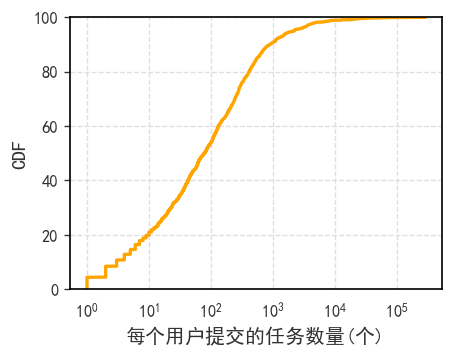

In [76]:
user_task_count = dfa.groupby('user').count()[['job_name']]
plt.figure(figsize=(4,3), dpi=300)
plot_data_cdf(user_task_count['job_name'], xlog=True,
              ylabel='CDF',xlabel='每个用户提交的任务数量(个)',
              xticks=[1,10,100,10**3,10**4,10**5])

In [59]:
user_task_count.describe()

,job_name
count,1433.000000
mean,879.916260
std,8439.707351
min,1.000000
25%,16.000000
50%,79.000000
75%,301.000000
max,284900.000000


### 任务对资源需求的分布

In [65]:
def plot_data_cdfs(data, datalabel=None, inverse=False, xlabel=None, title=None, xlog=False, ylog=False, xticks=None, figsize=(4,3), dpi=120, xlim=None, ylim=None, ylabel=None, yticks=None, savefig=None, loc='best', fontsize=None):
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.axes()
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    for i, d in enumerate(data):
        if type(data) == pd.DataFrame:
            d.dropna(inplace=True)
        x, y = get_cdf(d, inverse)
        label = datalabel[i] if datalabel is not None else None
        plt.plot(x, y, label=label, linestyle=linestyle_list[i % len(linestyle_list)][1])
    if datalabel is not None: plt.legend(loc=loc, fontsize=fontsize)
    if xlog: plt.xscale('log')
    if ylog: plt.yscale('log')
    plt.ylim(0, 100) if ylim is None else plt.ylim(ylim)
    if xlim is not None: plt.xlim(xlim)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is None:
        plt.ylabel('CCDF') if inverse is True else plt.ylabel('CDF')
    else:
        plt.ylabel(ylabel)
    if title is not None: plt.title(title)
    if xticks is not None: plt.xticks(xticks)
    if yticks is not None: plt.yticks(yticks)
    plt.grid(alpha=.3, linestyle='--')
    if savefig is not None:
        plt.savefig('/tmp/figures/{}.pdf'.format(savefig),bbox_inches='tight')
    else:
        plt.show()

In [84]:
data_df.head()

,job_name,task_name,inst_num,status,start_time,end_time,gpu_type,inst_id,user,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload,cpu_usage,gpu_wrk_util,avg_mem,avg_gpu_wrk_mem,plan_cpu,plan_gpu,plan_mem,cap_cpu,cap_gpu,cap_mem,plan_gpu_minus_usage_over_capacity,plan_cpu_minus_usage_over_capacity,plan_mem_minus_usage_over_capacity
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,MISC,990f1799a5093b62142b101c0227875b81c7f0329301df98af1148ec8724,58540f191766,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.0,43.450000,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN,350.353167,77.468451,24.306558,4.184025,600.0,50.0,29.296875,96,8,512,-0.034336,0.026005,0.009747
1,455c3dec270f4777ad67721c,tensorflow,1.0,Terminated,3399583.0,3399732.0,MISC,d94b4b01a6dd6c1865972cd628abe206422143ef37e6d449d4b2e862e574,ebba56ec23b9,Terminated,3399583.0,3399732.0,149.0,Terminated,3399681.0,3399732.0,51.0,0.850000,98.0,1970-02-09 16:19:43+08:00,NaN,5a3163d07db392e47b6f0d063906592f,NaN,117.888889,0.333333,1.870295,0.069743,600.0,100.0,29.296875,96,8,512,0.124583,0.050220,0.053568
2,ba64aa2f0feff18428923e92,tensorflow,1.0,Terminated,2152271.0,2158213.0,MISC,af71dfe31db0378561e1bea2c26605f67cb7611f0d38661b43881a1c6006,de69ddc1064e,Terminated,2152271.0,2158213.0,5942.0,Terminated,2152280.0,2158213.0,5933.0,98.883333,9.0,1970-01-26 05:51:11+08:00,NaN,f94dcf2c0efdf3fd36f75dbe1709c43f,NaN,139.502103,4.408403,12.811959,4.212840,600.0,50.0,29.296875,96,8,512,0.056989,0.047969,0.032197
3,704783be2a4b7f88b8d2e4ee,worker,100.0,Failed,2172980.0,NaN,MISC,a63da076c1210109040acf759e2c1d00b8abc2d84305990a5941d0142690,cfcb2e0deb93,Failed,2172974.0,2173216.0,NaN,Interrupted,2172995.0,NaN,NaN,NaN,15.0,1970-01-26 11:36:20+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN,4152.975415,582.481221,821.026606,20.235918,27600.0,460.0,449.218750,4416,368,23552,-0.003328,0.053096,-0.015787
4,bce3b9c55772f9d1e85fe796,PyTorchWorker,4.0,Failed,2374681.0,NaN,V100,8dd676ab7fef90186d5813c5255ce4e89b50bdd9854225e7fa082289c88f,11b3ab54fc9f,Failed,2374681.0,NaN,NaN,Interrupted,2374699.0,2378674.0,NaN,NaN,18.0,1970-01-28 19:38:01+08:00,V100,a2e43ea2be689ce60787b3174f3ffbbf,NaN,0.000000,0.000000,0.009766,0.000000,800.0,200.0,20.000000,192,16,1024,0.125000,0.041667,0.019522


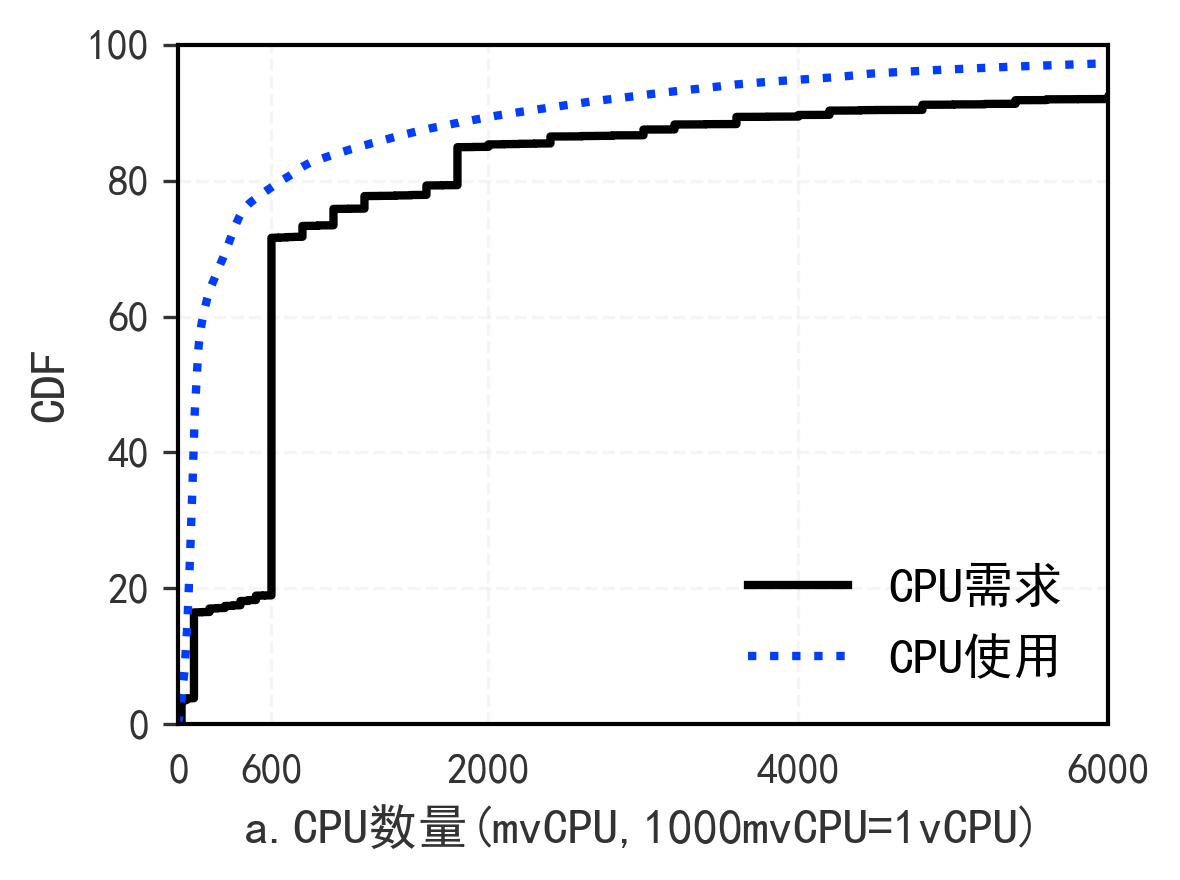

In [80]:
data_df = dfas
plot_data_cdfs([data_df['plan_cpu'].dropna(), data_df['cpu_usage'].dropna()], ['CPU需求', 'CPU使用'],
               xlabel='a.CPU数量(mvCPU,1000mvCPU=1vCPU)', xlim=(0, 6000), ylabel='CDF', xticks=[0,600,2000,4000,6000], dpi=300)

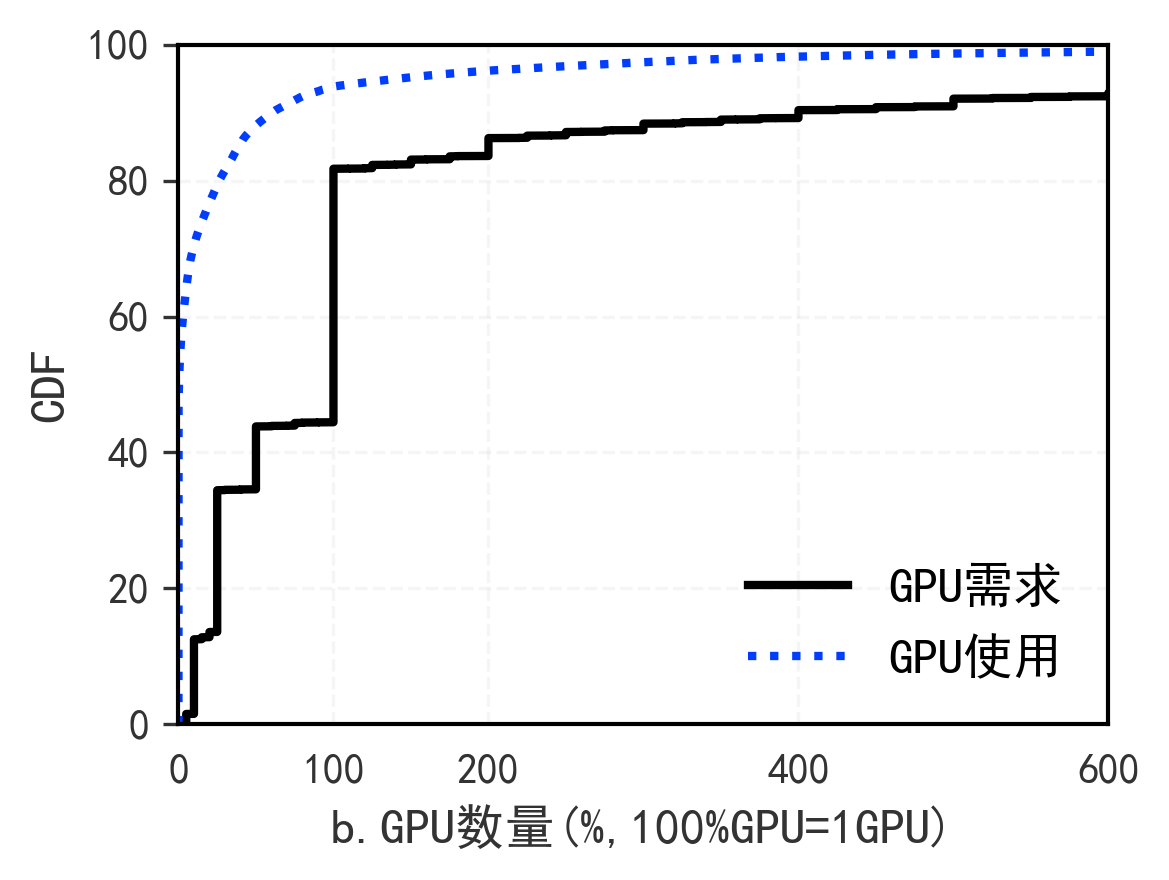

In [81]:
data_df = dfas
plot_data_cdfs([data_df['plan_gpu'].dropna(), data_df['gpu_wrk_util'].dropna()], ['GPU需求', 'GPU使用'],
               xlabel='b.GPU数量(%,100%GPU=1GPU)', xlim=(0, 600), ylabel='CDF', xticks=[0,100,200,400,600], dpi=300,loc='lower right')

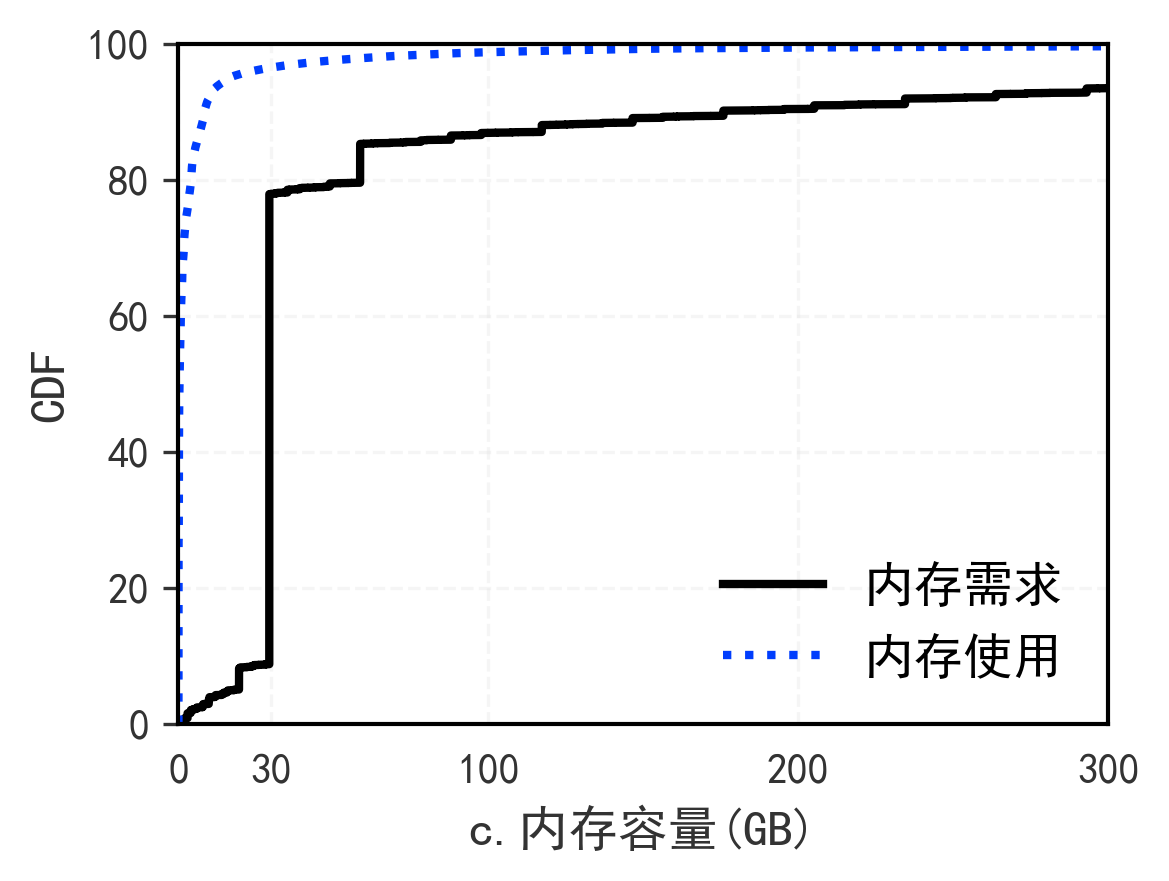

In [82]:
data_df = dfas
plot_data_cdfs([data_df['plan_mem'].dropna(), data_df['avg_gpu_wrk_mem'].dropna()], ['内存需求', '内存使用'],
               xlabel='c.内存容量(GB)', xlim=(0, 300), ylabel='CDF', xticks=[0,30,100,200,300], dpi=300)

In [73]:
def plan_minus_usg_over_cap_task(dfas):
    dfas['plan_gpu_minus_usage_over_capacity'] = (dfas['plan_gpu'] - dfas['gpu_wrk_util']) / (100 * dfas['cap_gpu'])
    dfas['plan_cpu_minus_usage_over_capacity'] = (dfas['plan_cpu'] - dfas['cpu_usage']) / (100 * dfas['cap_cpu'] )
    dfas['plan_mem_minus_usage_over_capacity'] = (dfas['plan_mem'] - dfas['avg_mem']) / dfas['cap_mem']

    dfas_task = dfas.groupby(['job_name','task_name'])[['plan_gpu_minus_usage_over_capacity','plan_cpu_minus_usage_over_capacity','plan_mem_minus_usage_over_capacity']].mean()

    pgu_datas, pgu_label, ugp_datas, ugp_label = [], [], [], []
    for device in ['cpu','gpu','mem']:
        apu = dfas_task[~dfas_task['plan_{}_minus_usage_over_capacity'.format(device)].isnull()]
        pgu = dfas_task[dfas_task['plan_{}_minus_usage_over_capacity'.format(device)] > 0]
        ugp = dfas_task[dfas_task['plan_{}_minus_usage_over_capacity'.format(device)] < 0]
        print("{}: plan > usage: {:.2f}%, plan < usage: {:.2f}%".format(
            device, 100 * len(pgu) / len(apu), 100 * len(ugp) / len(apu)    ))
        pgu_label.append("{} {:.2f}%".format(device, 100 * len(pgu) / len(apu)))
        pgu_datas.append(pgu['plan_{}_minus_usage_over_capacity'.format(device)])
        ugp_label.append("{} {:.2f}%".format(device, 100 * len(ugp) / len(apu)))
        ugp_datas.append(-ugp['plan_{}_minus_usage_over_capacity'.format(device)])

    return pgu_datas, ugp_datas, pgu_label, ugp_label

cpu: plan > usage: 84.46%, plan < usage: 15.51%
gpu: plan > usage: 98.02%, plan < usage: 1.97%
mem: plan > usage: 95.88%, plan < usage: 4.12%


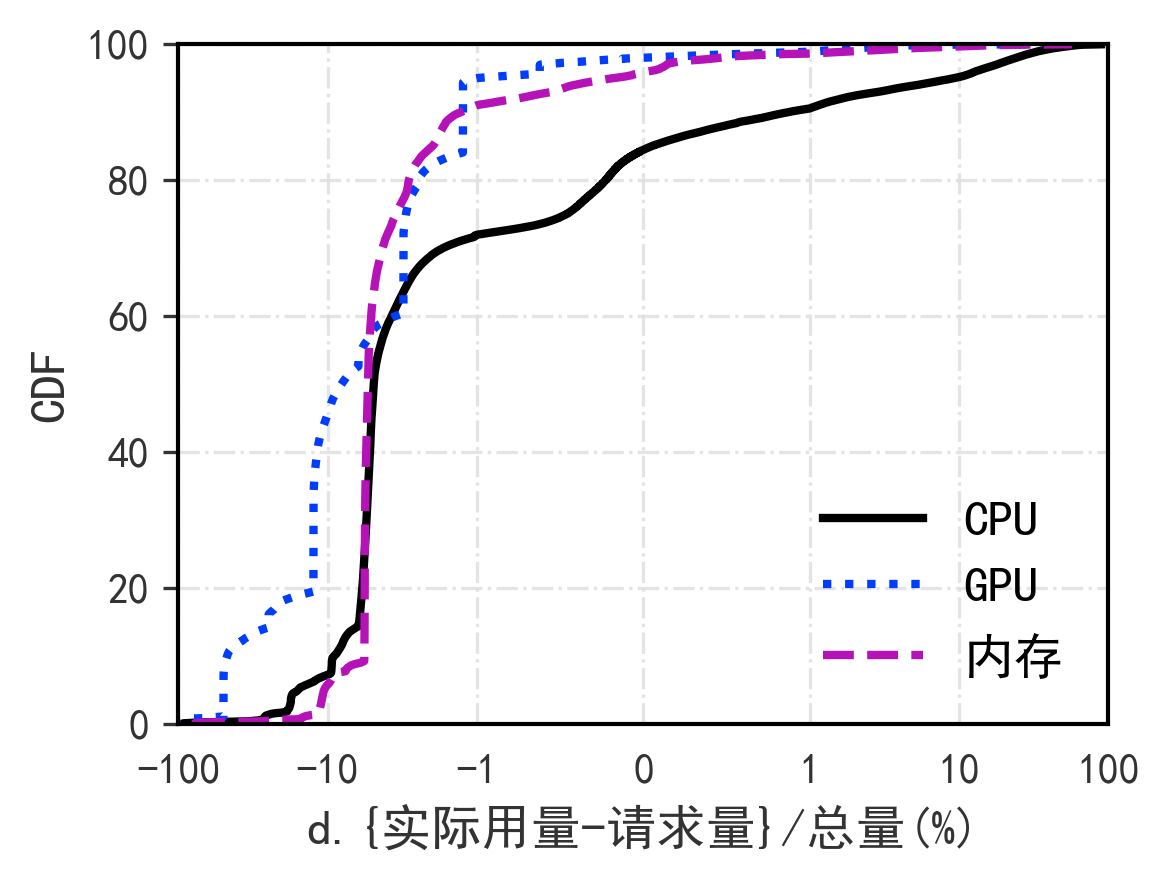

In [83]:
pgu_datas, ugp_datas, pgu_label, ugp_label = plan_minus_usg_over_cap_task(dfas)
data = [(100 * ugp_datas[i]).tolist() + (-100 * pgu_datas[i]).tolist() for i in [0,1,2]]
datalabel = ['CPU','GPU','内存']

from matplotlib.ticker import StrMethodFormatter, NullFormatter
fig, ax = plt.subplots(dpi=300, figsize=(4,3))
for i, d in enumerate(data):
    if type(data) == pd.DataFrame:
        d.dropna(inplace=True)
    x, y = get_cdf(d)
    label = datalabel[i] if datalabel is not None else None
    ax.plot(x, y, label=label, linestyle=linestyle_list[i % len(linestyle_list)][1])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_xscale('symlog', linscale=1, linthresh=1)
ax.set_yticks([0,20,40,60,80,100])
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.set_xlim([-100, 100])
ax.set_ylim([0,100])
ax.grid(alpha=0.8, linestyle='-.')
plt.ylabel('CDF')
plt.xlabel('d.{实际用量-请求量}/总量(%)')
ax.legend()

# 分析数据对不同计算资源需求的相关性

### 抽取相关数据进行并进行标准化缩放

In [86]:
dfw_soruce = dfws.drop(columns=['status', 'start_time', 'end_time', 'machine', 'runtime', 'start_date', 'inst_num', 'status_t', 'start_time_t', 'end_time_t', 'gpu_type', 'user', 'gpu_type_spec', 'group', 'workload', 'cap_cpu', 'cap_mem', 'cap_gpu', 'gpu_name', 'read', 'write', 'read_count', 'write_count'])

In [89]:
dfw_soruce = dfw_soruce.drop(columns=['job_name', 'task_name', 'inst_name', 'worker_name', 'inst_id'])

In [92]:
dfw_soruce.describe()

,plan_cpu,plan_mem,plan_gpu,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem
count,3.019349e+06,3.019349e+06,3.019349e+06,3.013538e+06,3.019349e+06,3.018143e+06,3.019349e+06,3.019349e+06,3.019349e+06
mean,6.046321e+02,2.708919e+01,5.719780e+01,2.588085e+02,1.041643e+01,5.534718e+00,1.061766e+01,1.714197e+00,2.328954e+00
std,5.734080e+02,2.134651e+01,5.972745e+01,5.673483e+02,2.980433e+01,1.060131e+01,5.701347e+01,6.023534e+00,7.655909e+00
min,1.000000e+00,3.906250e-03,1.000000e+00,0.000000e+00,0.000000e+00,9.765625e-04,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+02,1.757812e+01,2.500000e+01,5.729412e+01,0.000000e+00,7.343149e-01,1.415039e+00,1.225993e-01,1.884766e-01
50%,6.000000e+02,2.929688e+01,5.000000e+01,1.035070e+02,1.470443e+00,2.520196e+00,3.818359e+00,4.099837e-01,6.552734e-01
75%,6.000000e+02,2.929688e+01,1.000000e+02,2.386401e+02,9.759056e+00,6.413314e+00,1.016699e+01,1.831959e+00,2.502930e+00
max,9.000000e+03,4.000000e+02,8.000000e+02,9.206331e+03,7.920000e+02,3.916291e+02,2.757586e+03,2.532296e+02,2.536465e+02


### 进行归一化或者标准化
z-score标准化

In [98]:
from sklearn import preprocessing
from pandas import DataFrame

dfw_soruce_scale = {}

dfw_soruce_scale = DataFrame(dfw_soruce_scale)

In [101]:
dfw_soruce_scale['plan_cpu'] = preprocessing.scale(dfw_soruce['plan_cpu'])
dfw_soruce_scale['plan_mem'] = preprocessing.scale(dfw_soruce['plan_mem'])
dfw_soruce_scale['plan_gpu'] = preprocessing.scale(dfw_soruce['plan_gpu'])
dfw_soruce_scale['cpu_usage'] = preprocessing.scale(dfw_soruce['cpu_usage'])
dfw_soruce_scale['gpu_wrk_util'] = preprocessing.scale(dfw_soruce['gpu_wrk_util'])
dfw_soruce_scale['avg_mem'] = preprocessing.scale(dfw_soruce['avg_mem'])
dfw_soruce_scale['max_mem'] = preprocessing.scale(dfw_soruce['max_mem'])
dfw_soruce_scale['avg_gpu_wrk_mem'] = preprocessing.scale(dfw_soruce['avg_gpu_wrk_mem'])
dfw_soruce_scale['max_gpu_wrk_mem'] = preprocessing.scale(dfw_soruce['max_gpu_wrk_mem'])

In [102]:
dfw_soruce_scale.describe()

,plan_cpu,plan_mem,plan_gpu,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem
count,3.019349e+06,3.019349e+06,3.019349e+06,3.013538e+06,3.019349e+06,3.018143e+06,3.019349e+06,3.019349e+06,3.019349e+06
mean,-5.651680e-17,-4.277354e-17,-4.085325e-18,8.840941e-17,3.395056e-16,-6.281107e-17,6.890456e-18,-4.721657e-17,-1.855340e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.052710e+00,-1.268839e+00,-9.409041e-01,-4.561722e-01,-3.494940e-01,-5.219869e-01,-1.862307e-01,-2.845833e-01,-3.042035e-01
25%,-3.568700e-01,-4.455561e-01,-5.390788e-01,-3.551864e-01,-3.494940e-01,-4.528126e-01,-1.614113e-01,-2.642299e-01,-2.795850e-01
50%,-8.078158e-03,1.034214e-01,-1.205107e-01,-2.737321e-01,-3.001574e-01,-2.843540e-01,-1.192578e-01,-2.165196e-01,-2.186129e-01
75%,-8.078158e-03,1.034214e-01,7.166254e-01,-3.554853e-02,-2.205645e-02,8.287615e-02,-7.904544e-03,1.955036e-02,2.272438e-02
max,1.464118e+01,1.746941e+01,1.243653e+01,1.577078e+01,2.622383e+01,3.641952e+01,4.818105e+01,4.175546e+01,3.282661e+01


In [121]:
dfw_source_zh = dfw_soruce_scale.rename(columns={
    'plan_cpu': 'CPU需求',
    'plan_mem':'内存需求',	
    'plan_gpu':'GPU需求',	
    'cpu_usage':'CPU使用',	
    'gpu_wrk_util':'GPU使用',	
    'avg_mem':'平均内存使用',
    'max_mem':'最大内存使用',	
})

dfw_source_zh = dfw_source_zh.drop(columns=['avg_gpu_wrk_mem', 'max_gpu_wrk_mem'])


In [122]:
dfw_source_zh.head()

,CPU需求,内存需求,GPU需求,CPU使用,GPU使用,平均内存使用,最大内存使用
0,-0.008078,0.103421,-0.539079,-0.453316,-0.349494,-0.448714,-0.171894
1,4.526216,0.103421,2.390898,-0.192969,0.488505,2.032589,0.796165
2,-0.008078,0.125381,-0.539079,-0.447409,-0.349494,0.616017,0.025805
3,-0.008078,0.103421,-0.539079,-0.455827,-0.349494,-0.482980,-0.178797
4,-0.880058,0.103421,0.716625,-0.436517,-0.349494,2.144107,0.309883


#### 计算相关性矩阵

In [123]:
dfw_soruce_corr = dfw_source_zh.corr()

### 通过热力图进行相关性分析

In [124]:
import seaborn as sns
%matplotlib inline
# sns.set(font_scale=1.5)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题-设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题


C:\Users\liduo\AppData\Local\Temp\ipykernel_9980\218848958.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(dfw_soruce_corr, dtype=np.bool)


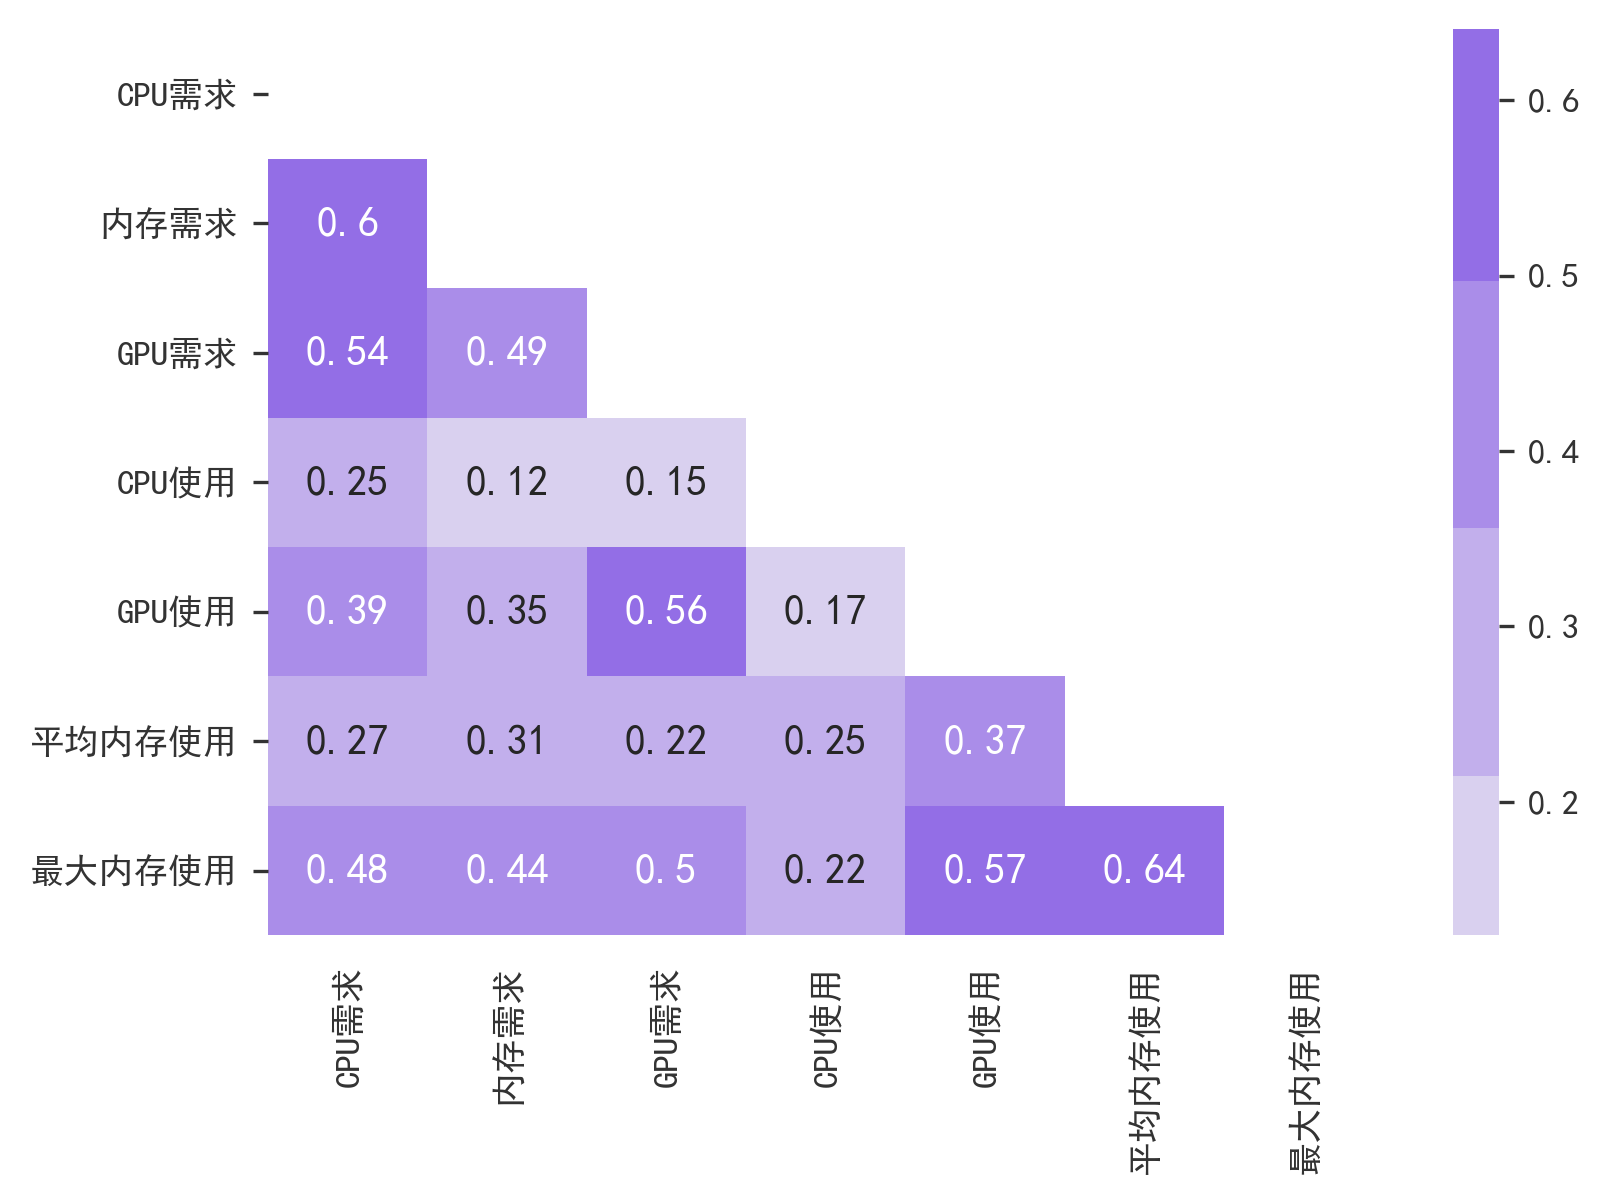

In [125]:
# 热力图
mask = np.zeros_like(dfw_soruce_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


plt.figure(dpi=300)
sns.heatmap(
    dfw_soruce_corr,
    cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9), 
    annot=True,fmt='.2',
    mask = mask,
    center = 0
    )
plt.show()